In [31]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]



mean = cards_to_age["age"].mean()
threshold = .005+(mean/2000)
shuffle_role = random.random()
print(f"{shuffle_role=:.6f}; {threshold=:.6f}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications 
priority_headers = [
    "Django", 
    "Python + Oauth2.0",
    "Microsoft Purview"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

shuffle_role=0.030543; threshold=0.041841


In [33]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Ansible,128.144855,3.203621,11.531507,40
ODBC,88.684207,5.542763,45.579889,16
Network Terms,126.722258,8.448151,41.749617,15
"Everything is Tuberculosis, Green",236.993650,10.304072,48.900145,23
Python + Oauth2.0,110.370630,15.767233,40.459693,7
"The Mines of the Behemoth, Shea",871.928654,17.794462,142.213604,49
eDiscovery,1014.189107,19.135644,147.230173,53
Exchange Online and Defender,753.231846,19.313637,172.903383,39
Ubuntu,532.648476,20.486480,134.977257,26
Python,1042.993828,20.859877,157.613436,50


# Histogram

sum of ages: ~22245.52


<Axes: >

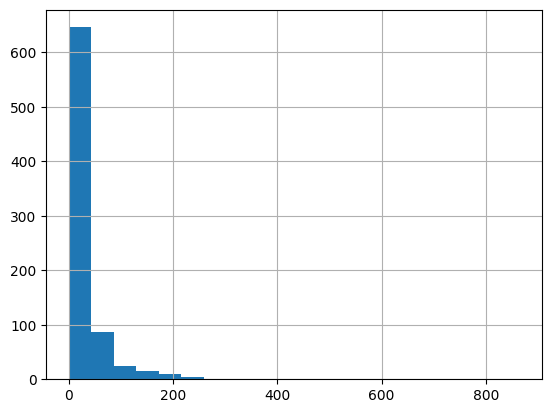

In [34]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~22245.52


<Axes: >

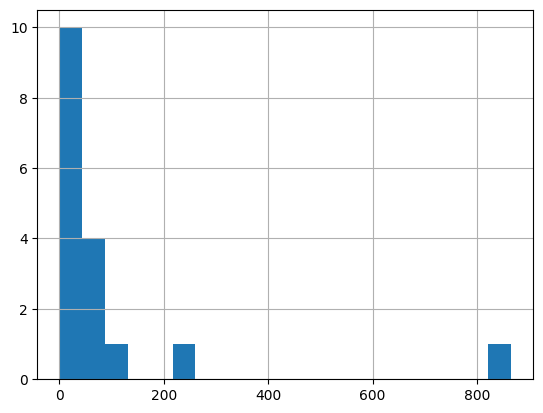

In [46]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='CCH Tax Forms Project']['age'].hist(bins=20)

# Completely Random Shuffle

In [36]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [37]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [38]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [39]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [40]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [41]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=existing_cards.shape[0]//100
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

floor dividing for n-fold
Cards found: 792
Total card age: 22245.52


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
206,Power BI,Q: What is VertiPaq and why is it relevant whe...,2a90a97bd1a8825e67d41156094bdac0,31.126110,22.625235,-31.126110,67.875706,0.320425,3,0,0,-31.126110
449,Power BI,What’s the difference between SUMMARIZE and SU...,e9ad423a7671d3e507054436d1b536aa,19.031025,22.625235,-31.126110,67.875706,0.320425,3,1,0,-19.031025
374,Power BI,Q: What are the risks of using a static RangeS...,87a77d8eab93c18d9504942557a93586,17.718572,22.625235,-31.126110,67.875706,0.320425,3,2,0,-17.718572
209,Python + Oauth2.0,base64.b64encode\n\nEncodes the client ID and ...,a13aab8f4c95ed7b04ce745d2ec8c1b3,40.459693,15.767233,-40.459693,110.370630,0.374089,7,0,0,-40.459693
332,Python + Oauth2.0,auth_request_url\n\nThe full URL constructed f...,311db54303101cf678005a47f3c448b7,18.822161,15.767233,-40.459693,110.370630,0.374089,7,1,0,-18.822161
403,Python + Oauth2.0,Authorization Code Flow\n\nAn OAuth 2.0 proces...,d4850cbaef38ddd979d113a4157aef95,17.967427,15.767233,-40.459693,110.370630,0.374089,7,2,0,-17.967427
196,Python + Oauth2.0,requests.post\n\nSends an HTTP POST request to...,bb16f2359d2f37fd8ac5b93c10bf9364,13.150613,15.767233,-40.459693,110.370630,0.374089,7,3,0,-13.150613
35,Python + Oauth2.0,handler.end_headers()\n\nFinalizes the HTTP re...,91ad05cd6046d3375013aa16d642650d,9.217609,15.767233,-40.459693,110.370630,0.374089,7,4,0,-9.217609
165,Python + Oauth2.0,webbrowser.open()\n\nA Python function that la...,16a129ebed05529cf3f614e52dddb6bc,6.184117,15.767233,-40.459693,110.370630,0.374089,7,5,0,-6.184117
338,Python + Oauth2.0,with socketserver.TCPServer(...) as httpd\n\nA...,dc67a0a9a3b4f64968f2a85345963025,4.569009,15.767233,-40.459693,110.370630,0.374089,7,6,0,-4.569009



## Random

In [42]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [43]:
existing_cards.head(10)['age'].sum()

np.float64(178.24633576841939)

In [44]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
5,CCH Tax Forms Project,Disabling GenerateMeta in CCH Axcess export op...,0881e21379d3a9f0ad63b7c4f20a58f9,864.397623,92.726691,-864.397623,1576.353741,0.038707,17,0,0,-864.397623
3,Terraform Codebox,Terraform modules allow you to organize and re...,30dc7c65ccaa1883bdec852a7b452264,745.596796,51.423742,-745.596796,1542.712248,0.401138,30,0,0,-745.596796
13,Microsoft Purview,Related to business domains are data products....,5989fb1bcb3a2780f5f0720e9aef312a,347.097625,43.789159,-347.097625,1576.409714,0.389479,36,0,0,-347.097625
39,Node.js and Vite,"""Failed to resolve import '@/components/ui/car...",556e229bc8e0e216c20cce4c223cef76,308.672051,50.799515,-308.672051,1625.584465,0.032196,32,0,0,-308.672051
1,JavaScript Concepts,"For objects, by default String returns an unhe...",cc7c3bc61969fcf92a11320dd7feed10,275.913907,43.178377,-275.913907,1424.886430,0.873676,33,0,0,-275.913907
30,JavaScript Concepts,"In many cases, it makes sense to assign a more...",a7297b840cb42c00f43f99692be05833,251.038189,43.178377,-275.913907,1424.886430,0.873676,33,1,0,-251.038189
44,Node.js and Vite,Preflight Checks (shadcn)\nshadcn’s built-in v...,4bb54314dbd00471f39cec846bc1cfe2,241.597036,50.799515,-308.672051,1625.584465,0.032196,32,1,0,-241.597036
72,Microsoft Purview,Steps to create a DLP policy\n Choose what ...,4f0b5e031371a6388fc727c4144921c5,239.548535,43.789159,-347.097625,1576.409714,0.389479,36,1,0,-239.548535
94,CCH Tax Forms Project,Calling elem.clear() in Python’s ElementTree f...,29f39569d5ccccfb3ed756311cc7b22d,233.620843,92.726691,-864.397623,1576.353741,0.038707,17,1,0,-233.620843
34,Active Directory and Azure Files,Access Control Entry (ACE)\nAn individual line...,7c3aca1e0d5e7e16524bf00593c3c22f,226.871726,44.263477,-226.871726,1327.904298,0.941186,30,0,0,-226.871726


In [45]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 28.088'